# Environment 

In [1]:
cd ../..

/disk1/home/svo6059/masters/spikelearn


## Imports

In [2]:
import sys
sys.path.append('.')
import os
from spikelearn import frankenstein, shuffle_val_predict
from spikelearn.models import shuffle_cross_predict
from spikelearn.data import io, SHORTCUTS, select, to_feature_array
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
from spikelearn import bootstrapping as bs

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_predict, GroupKFold
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, GroupShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_validate

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from scipy.stats import pearsonr
pearson = lambda t, p: pearsonr(t, p)[0]

from sklearn.model_selection import GroupShuffleSplit

from spikelearn.data.selection import select, to_feature_array, frankenstein
from spikelearn.data import io, SHORTCUTS
from spikelearn.models import shuffle_val_predict
from sklearn.metrics import make_scorer, cohen_kappa_score

from scipy.stats import ttest_rel

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [360]:
from scipy.stats import ttest_ind

In [3]:
from itertools import product
from spikelearn.models.shuffle_decoding import MonteCarloFeatures

from spikelearn.measures.univariate import bracketing

In [4]:
from sklearn.linear_model import BayesianRidge

In [424]:
from sklearn.metrics import accuracy_score

## Functions

In [426]:
@make_scorer
def cont_accuracy(y_true, y_pred):
    return accuracy_score(y_true, np.round(y_pred/100).astype(int)*100)

In [427]:
scoring={'Explained variance':'explained_variance', "Pearson's r":make_scorer(pearson), 'Accuracy':cont_accuracy}

def cross_val(df, clf, n_splits=100):
    res = cross_validate(clf, df.values, df.reset_index().time, df.reset_index().trial, 
                         cv = GroupShuffleSplit(n_splits), scoring=scoring, return_train_score=False)

    res = pd.DataFrame(res).filter(regex='test').melt()
    res.variable = res.variable.apply(lambda s: s[5:])
    return res

### Behavior


In [397]:
from scipy.optimize import curve_fit
from sklearn.metrics import explained_variance_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def dprime(pred):
    TP = pred.astype(int).sum()/len(pred)
    FP = (pred==False).astype(int).sum()/len(pred)
    return (norm.ppf(TP) - norm.ppf(FP))

def degrau(x, baixo, alto, th):
    return baixo*((x<th).astype(int)) + alto*((x>=th).astype(int))

def best_degrau(x, y):
    ths = x[2:-2]
    scores = np.array([((y - degrau(x, y[x<th].mean(), y[x>=th].mean(), th))**2).sum() for th in ths])
    th = ths[scores.argmin()]
    return y[x<th].mean(), y[x>=th].mean(), th
        
def compare_linear_vs_step(x,y, plot=True, return_raw = False):
    a, b = np.polyfit(x,y,1)
    linear_pred = a*x + b
    r_lin = explained_variance_score(y, linear_pred)

    #pars, _ = curve_fit(degrau, x, y, p0=[-.2,1,100], method='trf')
    step_pred = degrau(x, *best_degrau(x, y))
    r_step = explained_variance_score(y, step_pred)

    if plot:
        plt.plot(x,y, label='D prime')
        plt.plot(x, linear_pred, label= 'Regression, R^2: {:.2f}'.format(r_lin), linewidth=2)
        plt.plot(x, step_pred, label='Step, R^2: {:.2f}'.format(r_step), linewidth=2)
        plt.legend(loc='upper right')
    if return_raw:
        return linear_pred, step_pred
    else:
        return r_lin, r_step

# Animals learn fast

## They disengage in long sessions 

In [114]:
bhv = {}
for label in SHORTCUTS['groups']['eletro']:
    bhv[label] = select(io.load(label, 'behav_stats')).reset_index()
    bhv[label]['rat'] = int(label.split()[-1][0]) if '_2' in label else int(label.split()[-1])
    bhv[label]['day'] = 2 if '_2' in label else 1
    bhv[label]['label'] = label
    bhv[label]['percent_trial'] = bhv[label].trial/bhv[label].trial.max()*100
allr = pd.concat(bhv.values())

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [115]:
sns.set_palette('deep', color_codes=True)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


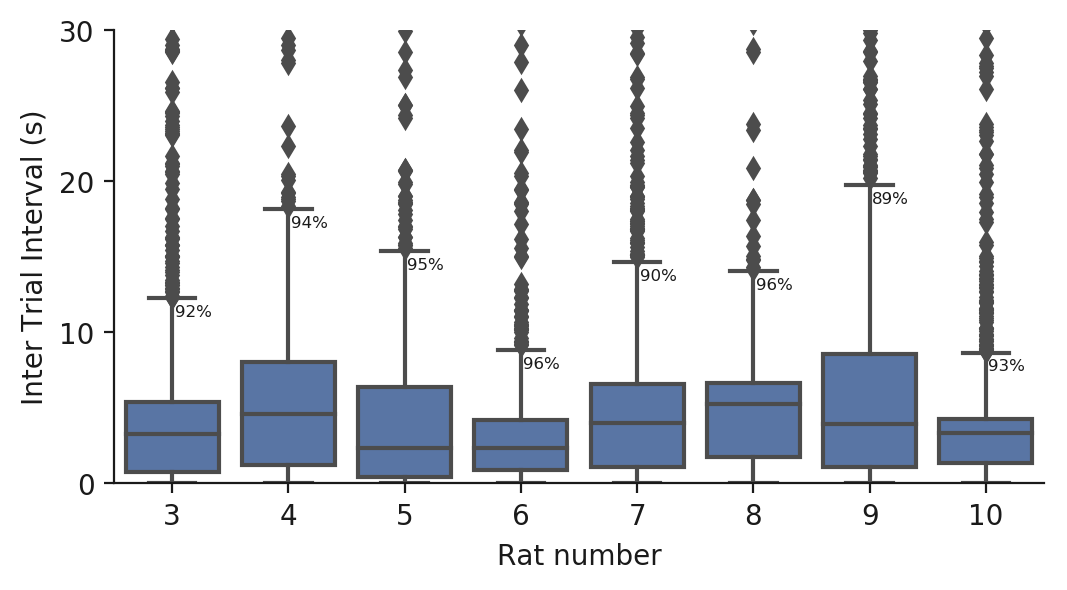

In [116]:
plt.figure(figsize=(6,3), dpi=200)
ax = sns.boxplot(y='intertrial_interval', x='rat', data = pd.concat(bhv.values()), color='b')
plt.ylim(0,30)
plt.ylabel('Inter Trial Interval (s)')
plt.xlabel('Rat number')
for rat in range(3,11):
    rdf = allr[allr.rat==rat]
    Q3 = rdf.intertrial_interval.quantile(.75)
    IQR = Q3 - rdf.intertrial_interval.quantile(.25)
    inside = (rdf.intertrial_interval < (Q3 + 1.5*IQR))
    ax.text(rat-3+.02, rdf[inside].intertrial_interval.max() - 1.2, 
            '{:.0%}'.format(inside.mean()), fontsize=6)
plt.yticks([0, 10, 20, 30])
sns.despine()

In [85]:
import matplotlib.gridspec as gridspec

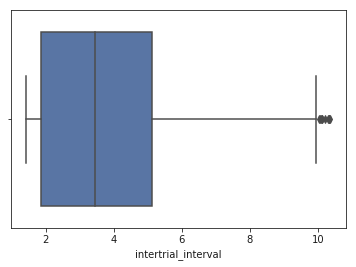

In [153]:
sns.boxplot(iti.rolling(30).mean())

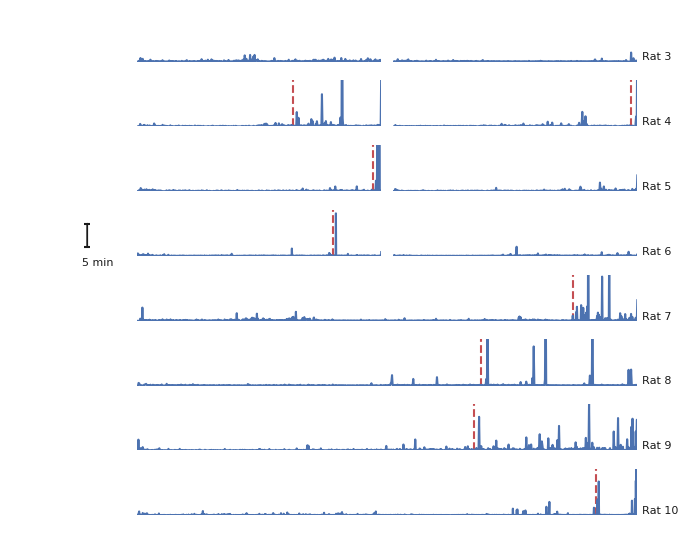

In [301]:
fig = plt.figure(figsize=(10,5), constrained_layout=False, dpi=100)
gs1 = gridspec.GridSpec(nrows=8, ncols=2, figure= fig, left=0, right=0.5, 
                        wspace=0.05, hspace=0.4, bottom=0,top=1)
shape = (8,2)
axes = {}
for label in allr.label.unique():
    rdf = allr[allr.label==label]
    day = rdf.day.values[0]
    rat = rdf.rat.values[0]
    if rat < 7:
        axes[label] = fig.add_subplot(gs1[rat-3, day-1])
    else:
        axes[label] = fig.add_subplot(gs1[rat-3, :])
    ax = axes[label]
    iti = rdf.set_index('percent_trial').intertrial_interval/10
#     plt.subplot2grid(shape, (rat-3, day-1), 1, 1 if rat < 7 else 2)
    ax.plot(rdf.percent_trial, rdf.intertrial_interval/60)
#     iti.rolling(5, center=False).mean().plot()
    
    Q3 = rdf.intertrial_interval.quantile(.75)
    IQR = Q3 - rdf.intertrial_interval.quantile(.25)
    b = (rdf.intertrial_interval.rolling(5).mean() > 60) #(Q3 + 1.5*IQR)
    ax.vlines(rdf[b.shift(-10).fillna(False)].percent_trial.min(), 0, 100, color='r', linestyles='--', linewidth=1.5)
    if rat > 2:
        ax.set_axis_off()
#     sns.despine(bottom=True, left=True, trim=True)
    ax.set_ylim([0,10])
    ax.set_xlim([0,100])
    if day==2 or rat > 6:
        if rat <7:
            ax.text(102,.3, 'Rat {}'.format(rat), horizontalalignment='left', fontsize=8)
        else:
            ax.text(101,.3, 'Rat {}'.format(rat), horizontalalignment='left', fontsize=8)
            
height = ax.get_position().height
# plt.arrow()
ax = fig.add_axes([-.1,.5, .1, height])
ax.set_ylim(0,10)
ax.arrow(.5, 4, 0, 5)
ax.hlines([4,9], .47, .53)
ax.set_xlim(0,1)
ax.text(.45,0, '5 min', fontsize=8)
ax.set_axis_off()
axes['ELI 3']
# fig.subplots_adjust(left=0, right=1, hspace=-2, wspace=0)

In [306]:
maxtrial = {}
for label in allr.label.unique():
    rdf = allr[allr.label==label]
    Q3 = rdf.intertrial_interval.quantile(.75)
    IQR = Q3 - rdf.intertrial_interval.quantile(.25)
    b = (rdf.intertrial_interval.rolling(5).mean() > 60) #(Q3 + 1.5*IQR)\
    maxtrial_rat = rdf[b.fillna(False)].trial.min()
    if maxtrial_rat is np.nan:
        maxtrial[label] = rdf.trial.max()+1
    else:
        maxtrial[label] = maxtrial_rat
print(maxtrial)


{'DRRD 7': 1049, 'DRRD 8': 561, 'DRRD 9': 637, 'DRRD 10': 1542, 'ELI 3': 544, 'ELI 4': 288, 'ELI 5': 501, 'ELI 6': 762, 'ELI 3_2': 626, 'ELI 4_2': 381, 'ELI 5_2': 438, 'ELI 6_2': 700}


## One session is enough 

In [367]:
pal = ['r','b']

### Group 1

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


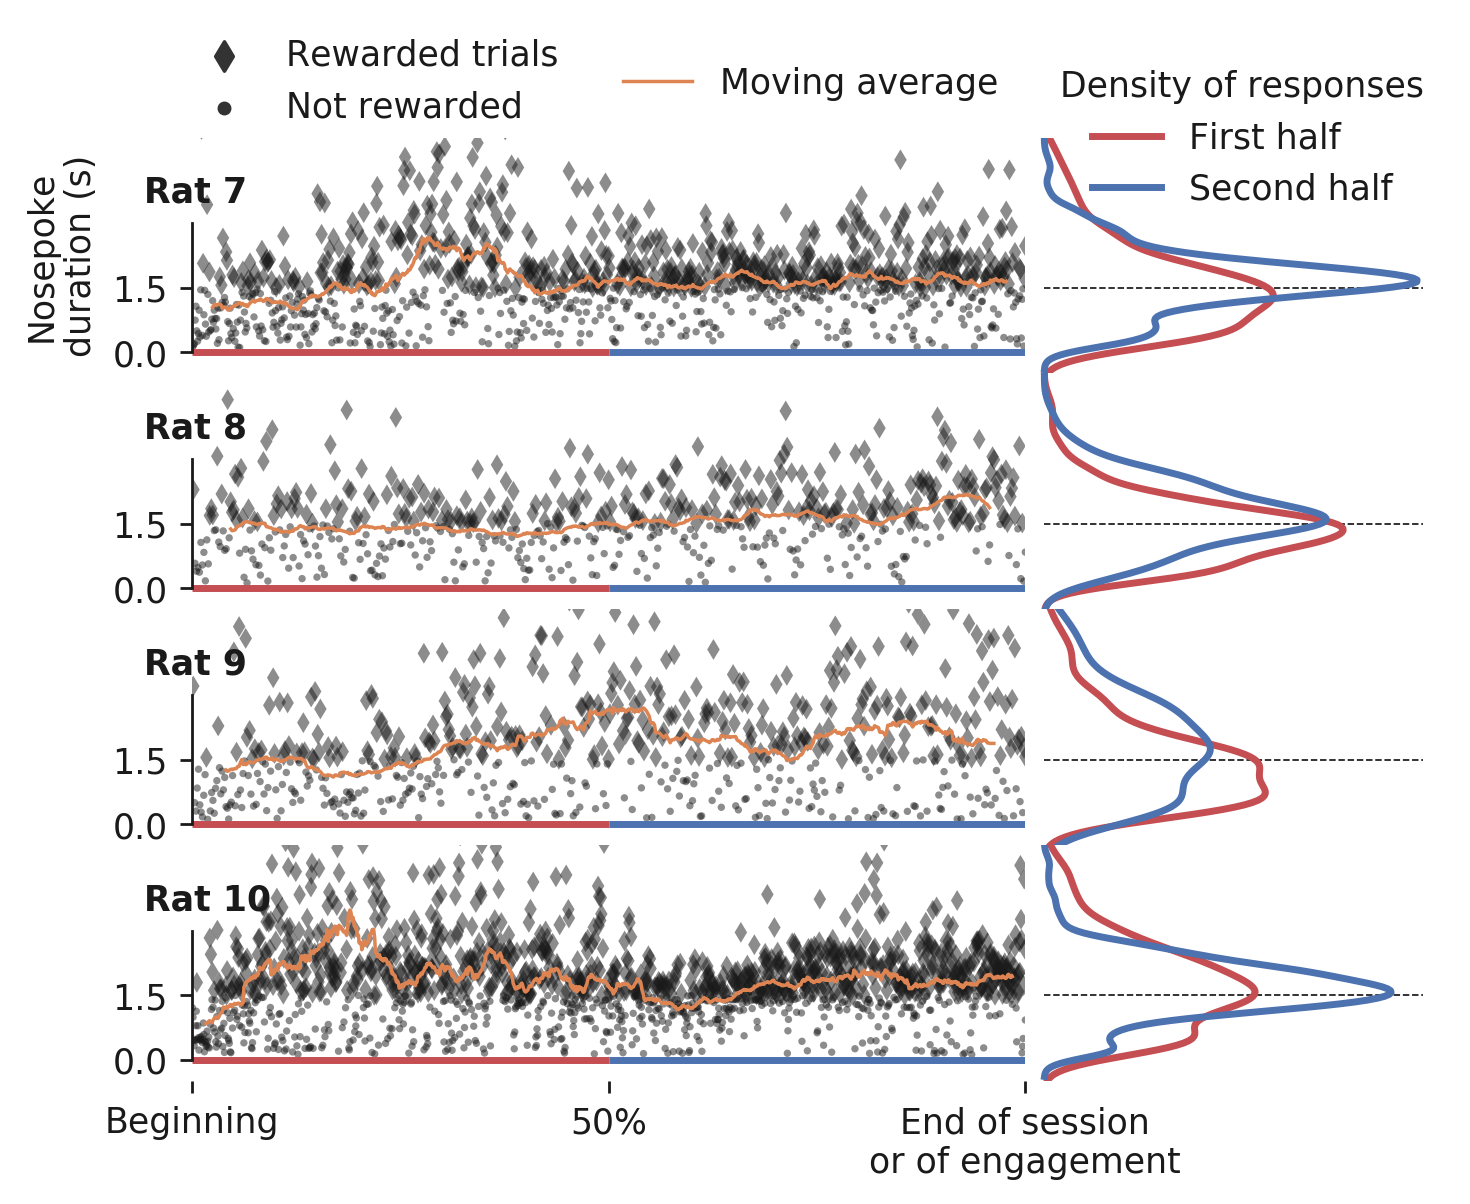

In [375]:
shape = (4,3)
ylim = (-.5, 5)
fig, ax = plt.subplots(*shape, figsize=(5,5), dpi=250)
fig.subplots_adjust(hspace=0, wspace=0, right=1, left=0)
i = 0
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[:4]):
    dur = select(io.load(label, 'behav_stats')).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['rewarded'] = dur.duration>1.5
    dur['rewarded'] = dur.rewarded.apply(lambda b: 'Rewarded trials' if b else 'Not rewarded')
    dur['first_half'] = dur.trial < dur.trial.median()
    dur['percent_trial'] = dur.trial/dur.trial.max()*100
    
    axs = plt.subplot2grid(shape,(i,0), 1, 2)
    sns.scatterplot(y='duration', x='percent_trial', style='rewarded', data=dur, color='k', markers=['.','d'],
                    style_order=['Not rewarded', 'Rewarded trials'], ax=axs, size=3, linewidth=0, alpha=.5)
    dur.set_index('percent_trial').duration.rolling(50, center=True)\
                                  .mean().plot(color=sns.color_palette('deep')[1], linewidth=1, label='Moving average')
    x = axs.get_legend_handles_labels()
    axs.set_xlim(0,100)
    axs.set_ylim(ylim)
    axs.set_yticks([0, 1.5])
    axs.set_xticks([])
    
    good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
    axs.legend(*good_labels, title='', frameon=True)
    axs.hlines(0, 0, 50, colors=pal[0], linewidth=2)
    axs.hlines(0, 50, 100, colors=pal[1], linewidth=2)
    axs.set_xlabel('')
    
    
    axd = plt.subplot2grid(shape,(i,2))
    sns.distplot(dur.duration[dur.first_half], vertical=True, hist=False, color=pal[0],
                 kde_kws= dict(linewidth=2,clip=(0,5)), label = 'First half')
    sns.distplot(dur.duration[dur.first_half==False], vertical=True, hist=False, color=pal[1],
                 kde_kws= dict(linewidth=2, clip=(0,5)), label = 'Second half')
    axd.hlines(1.5, 0, .7, linestyles='--', linewidth=.5)
    
    
    if i==1:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in ['Moving average']]))
        axs.legend(*good_labels, title='', frameon=False, loc=(.5,2.1))
        axd.legend().remove()
        axs.set_ylabel('')
    elif i!= 0: 
        axs.legend().remove()
        axd.legend().remove()
        axs.set_ylabel('')
    else:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
        axs.legend(*good_labels, title='', frameon=False, loc=(-.02,1))
        axd.legend(frameon=False, title='Density of responses', loc=(.05,.65))
        axs.set_ylabel('Nosepoke\nduration (s)')
        

    axs.text(-5.8, 3.5, 'Rat %d'%(i+7), weight = 'bold')
    
    axd.set_ylim(ylim)
    axd.set_axis_off()
    sns.despine(left=False, bottom=True)
    axs.spines['left'].set_bounds(0, 3)
axs.set_xticks([0, 50, 100])
axs.set_xticklabels(['Beginning', '50%', 'End of session\nor of engagement']);
# plt.tight_layout()


#### Hypothesis testing 

In [377]:
from scipy.stats import f_oneway

In [408]:
fh = []
sh = []
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[:4]):
    dur = select(io.load(label, 'behav_stats')).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['rewarded'] = dur.duration>1.5
    dur['first_half'] = dur.trial < dur.trial.median()
#     print(label)
#     print( f_oneway(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
#     print( ttest_ind(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
    
    fh.append(dur[dur.first_half].rewarded.mean())
    sh.append(dur[dur.first_half==False].rewarded.mean())
    
ttest_rel(sh, fh)

Ttest_relResult(statistic=3.5644840511793254, pvalue=0.03769964228044738)

### Group 2

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


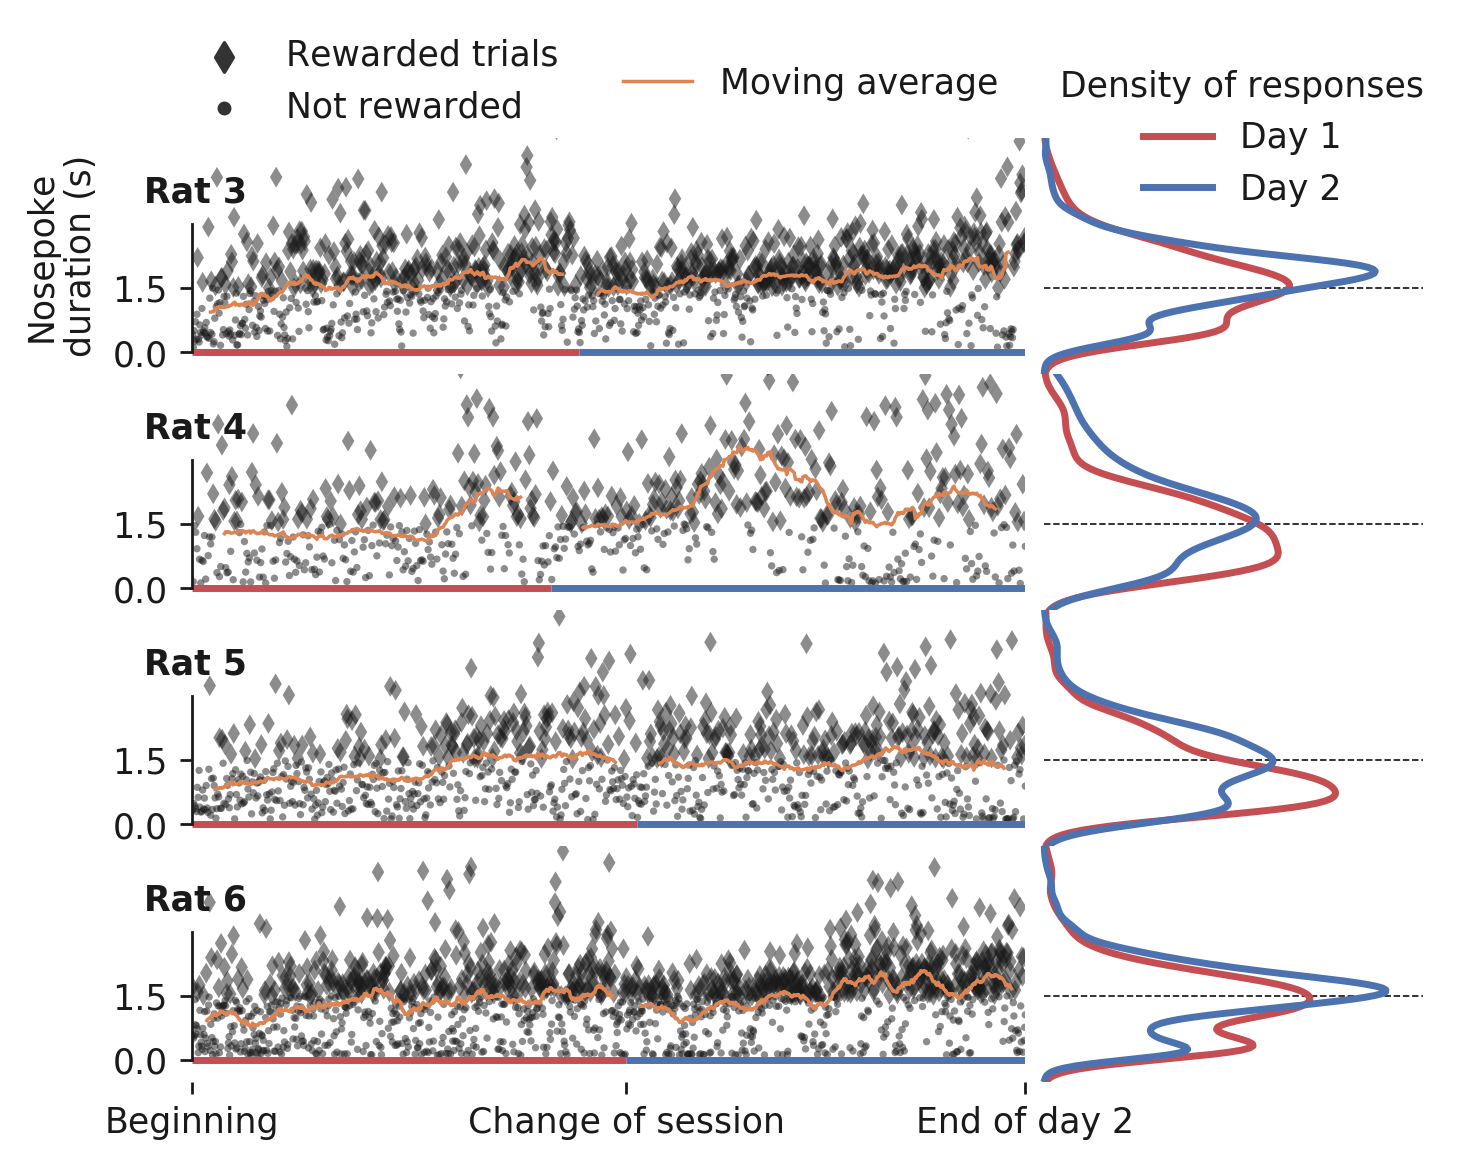

In [373]:
shape = (4,3)
ylim = (-.5, 5)
fig, ax = plt.subplots(*shape, figsize=(5,5), dpi=250)
fig.subplots_adjust(hspace=0, wspace=0, right=1, left=0)
i = 0
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[4:8]):
#     fig, ax = plt.subplots(figsize=(4,4))

    dur = select(io.load(label, 'behav_stats'), is_tired=False).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['first_half'] = True
    dur2 = select(io.load(label+'_2', 'behav_stats'), is_tired=False).reset_index()
    dur2 = select(dur2, _max_trial=maxtrial[label+'_2'])
    dur2['trial'] = dur2.trial + dur.trial.max()
    dur2['first_half'] = False
    dur = dur.append(dur2)
    dur['rewarded'] = dur.duration>1.5
    dur['rewarded'] = dur.rewarded.apply(lambda b: 'Rewarded trials' if b else 'Not rewarded')
#     dur['first_half'] = dur.trial < dur.trial.median()
    dur['percent_trial'] = dur.trial/dur.trial.max()*100
    
    axs = plt.subplot2grid(shape,(i,0), 1, 2)
    sns.scatterplot(y='duration', x='percent_trial', style='rewarded', data=dur, color='k', markers=['.','d'],
                    style_order=['Not rewarded', 'Rewarded trials'], ax=axs, size=3, linewidth=0, alpha=.5)
    dur[dur.first_half].set_index('percent_trial').duration.rolling(50, center=True)\
                                  .mean().plot(color=sns.color_palette('deep')[1], linewidth=1)
    dur[dur.first_half==False].set_index('percent_trial').duration.rolling(50, center=True)\
                              .mean().plot(color=sns.color_palette('deep')[1], linewidth=1, label='Moving average')

    x = axs.get_legend_handles_labels()
    axs.set_xlim(0,100)
    axs.set_ylim(ylim)
    axs.set_yticks([0, 1.5])
    axs.set_xticks([])
    
    good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
    
    
    final_first_sess = dur[dur.first_half].percent_trial.max()
    axs.hlines(0, 0, final_first_sess, colors=pal[0], linewidth=2)
    axs.hlines(0, final_first_sess, 100, colors=pal[1], linewidth=2)
    axs.set_xlabel('')
    
    
    axd = plt.subplot2grid(shape,(i,2))
    sns.distplot(dur.duration[dur.first_half], vertical=True, hist=False, color=pal[0],
                 kde_kws= dict(linewidth=2,clip=(0,5)), label = 'Day 1')
    sns.distplot(dur.duration[dur.first_half==False], vertical=True, hist=False, color=pal[1],
                 kde_kws= dict(linewidth=2, clip=(0,5)), label = 'Day 2')
    axd.hlines(1.5, 0., .7, linestyles='--', linewidth=.5)
    
    if i==1:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in ['Moving average']]))
        axs.legend(*good_labels, title='', frameon=False, loc=(.5,2.1))
        axd.legend().remove()
        axs.set_ylabel('')
    elif i!= 0: 
        axs.legend().remove()
        axd.legend().remove()
        axs.set_ylabel('')
    else:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
        axs.legend(*good_labels, title='', frameon=False, loc=(-.02,1))
        axd.legend(frameon=False, title='Density of responses', loc=(.05,.65))
        axs.set_ylabel('Nosepoke\nduration (s)')
        
    axs.text(-5.8, 3.5, 'Rat %d'%(i+3), weight = 'bold')

        
    axd.set_ylim(ylim)
    axd.set_axis_off()
    sns.despine(left=False, bottom=True)
    axs.spines['left'].set_bounds(0, 3)
axs.set_xticks([0, final_first_sess, 100])
axs.set_xticklabels(['Beginning', 'Change of session', 'End of day 2']);
# plt.tight_layout()


#### Hypothesis testing 

In [409]:
fh = []
sh = []
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[4:8]):
    dur = select(io.load(label, 'behav_stats'), is_tired=False).reset_index()
    dur = select(dur, _max_trial=maxtrial[label])
    dur['first_half'] = True
    dur2 = select(io.load(label+'_2', 'behav_stats'), is_tired=False).reset_index()
    dur2 = select(dur2, _max_trial=maxtrial[label+'_2'])
    dur2['trial'] = dur2.trial + dur.trial.max()
    dur2['first_half'] = False
    dur = dur.append(dur2)
    dur['rewarded'] = dur.duration>1.5
#     print(label)
#     print( f_oneway(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
#     print( ttest_ind(dur[dur.first_half].duration, dur[dur.first_half==False].duration) )
    
    fh.append(dur[dur.first_half].rewarded.mean())
    sh.append(dur[dur.first_half==False].rewarded.mean())
    
ttest_rel(sh, fh)

Ttest_relResult(statistic=20.7558782599815, pvalue=0.0002445851668064605)

### Some exploration 

In [414]:
fh_period = dur[dur.first_half].offset.max() - dur[dur.first_half].onset.min()
sh_period = dur[dur.first_half==False].offset.max() - dur[dur.first_half==False].onset.min()

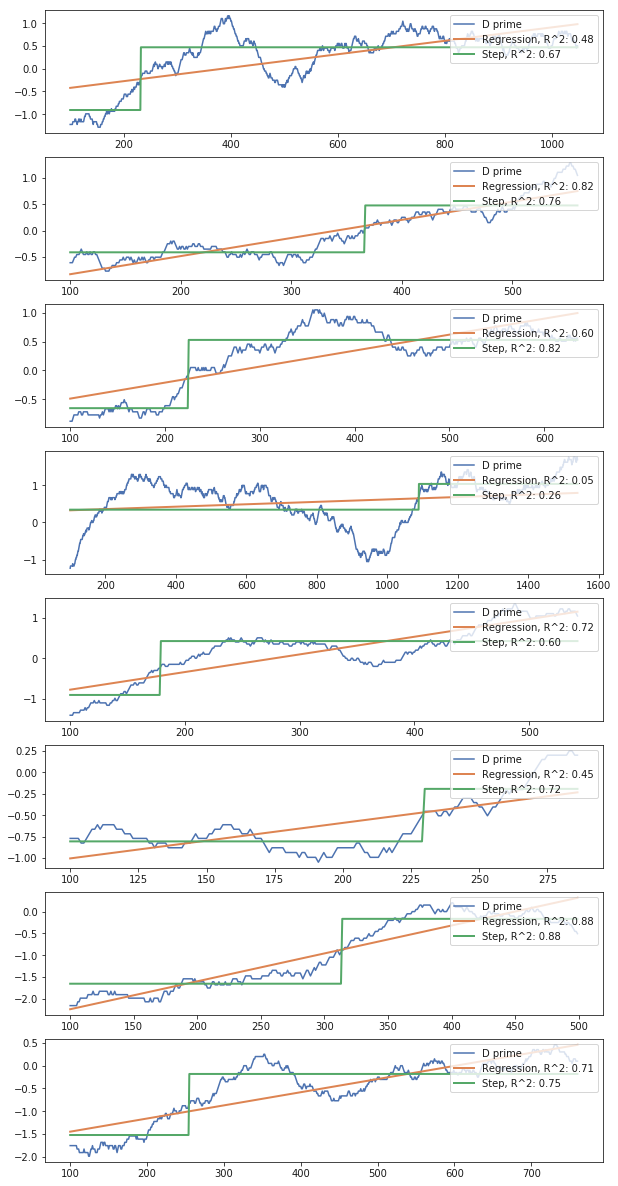

In [398]:
window = 100
plt.figure(figsize=(10,32))
for i, label in enumerate(SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats')).reset_index()
    b = select(b, _max_trial=maxtrial[label])
    b['rewarded'] = (b.duration>1.5)

    y = b.rewarded.rolling(window).apply(dprime, raw=True)[window:]
    x = b.index[window:]

    
    plt.subplot(12,1,1+i)
    l, s = compare_linear_vs_step(x, y);

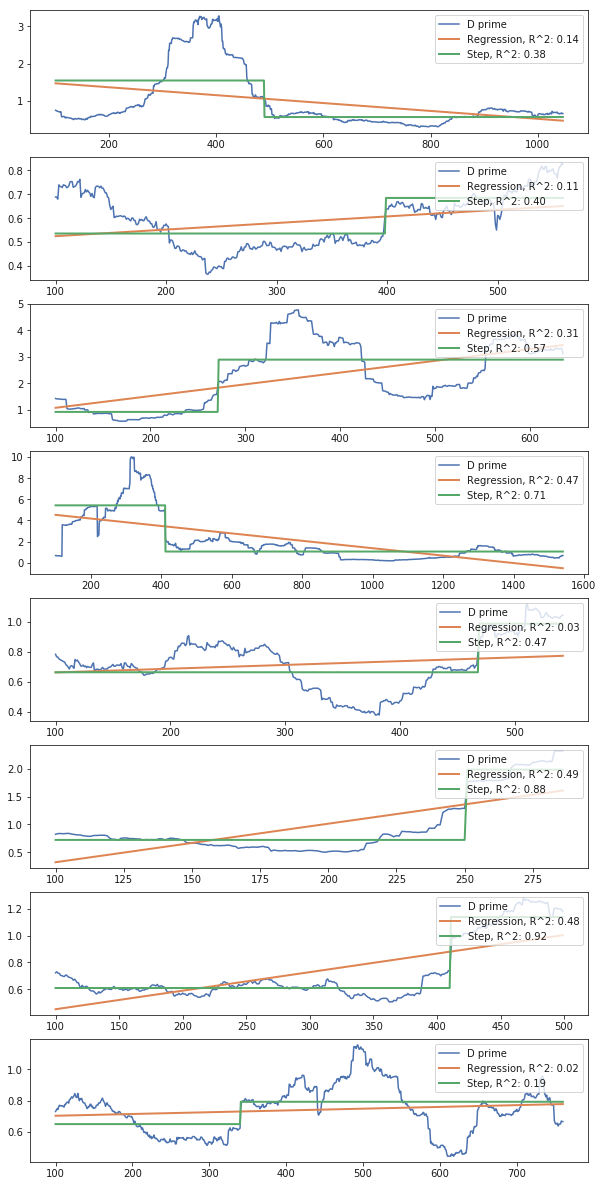

In [406]:
window = 100
plt.figure(figsize=(10,32))
for i, label in enumerate(SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats')).reset_index()
    b = select(b, _max_trial=maxtrial[label])
    b['rewarded'] = (b.duration>1.5)

    y = b.duration.rolling(window).apply(lambda dur: ((dur-1.5)**2).mean(), raw=True)[window:]
    x = b.index[window:]

    
    plt.subplot(12,1,1+i)
    l, s = compare_linear_vs_step(x, y);

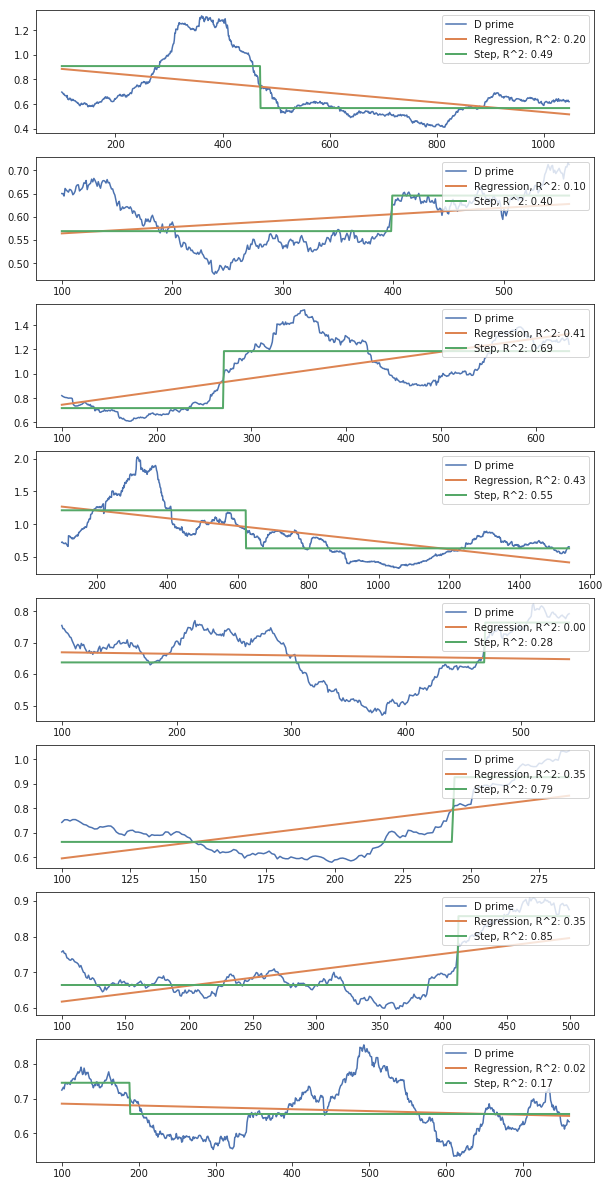

In [407]:
window = 100
plt.figure(figsize=(10,32))
for i, label in enumerate(SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats')).reset_index()
    b = select(b, _max_trial=maxtrial[label])
    b['rewarded'] = (b.duration>1.5)

    y = b.duration.rolling(window).apply(lambda dur: np.sqrt(((dur-1.5)**2)).mean(), raw=True)[window:]
    x = b.index[window:]

    plt.subplot(12,1,1+i)
    l, s = compare_linear_vs_step(x, y);

# Motor activity 

In [289]:
labels = SHORTCUTS['groups']['DRRD']
dfs = [select(io.load(label, 'no_smoothing_viz'), _min_duration=1., is_selected=True, is_tired=False) for label in labels]


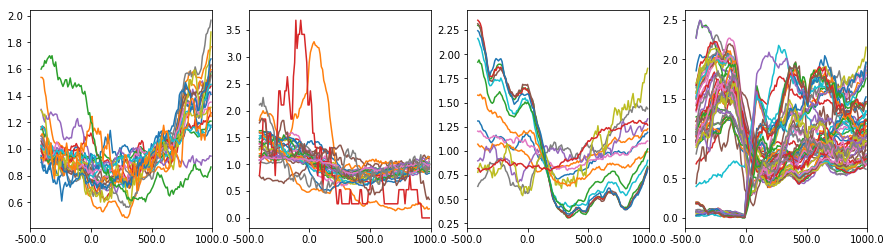

In [296]:
fig, ax = plt.subplots(1,4,figsize=(15,4))
for i in range(4):
    mean_activity = dfs[i].full.unstack(1).apply(lambda col: np.vstack(col.apply(lambda a: a[:150])).mean(axis=0))
    mean_activity = mean_activity/mean_activity.mean()
    mean_activity.rolling(10).mean().plot(ax = ax[i], legend=False)
    plt.sca(ax[i])
    locs, labels = plt.xticks()           # Get locations and labels
    plt.xticks(locs, locs*10 - 500)  # Set locations and labels
    plt.xlim(0,150)

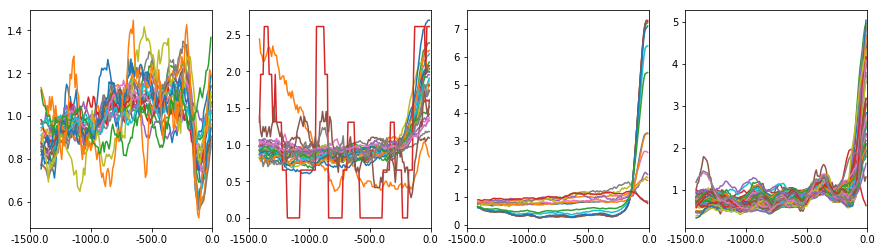

In [299]:
fig, ax = plt.subplots(1,4,figsize=(15,4))
for i in range(4):
    mean_activity = dfs[i].full.unstack(1).apply(lambda col: np.vstack(col.apply(lambda a: a[-150:])).mean(axis=0))
    mean_activity = mean_activity/mean_activity.mean()
    mean_activity.rolling(10).mean().plot(ax = ax[i], legend=False)
    plt.sca(ax[i])
    locs, labels = plt.xticks()           # Get locations and labels
    plt.xticks(locs, locs*10 - 1500)  # Set locations and labels
    plt.xlim(0,150)

# Time is represented in the neural activity

## We can predict time using the instantaneous firing rate

### Data loading

In [320]:
maxtrial

{'DRRD 7': 1049,
 'DRRD 8': 561,
 'DRRD 9': 637,
 'DRRD 10': 1542,
 'ELI 3': 544,
 'ELI 4': 288,
 'ELI 5': 501,
 'ELI 6': 762,
 'ELI 3_2': 626,
 'ELI 4_2': 381,
 'ELI 5_2': 438,
 'ELI 6_2': 700}

In [332]:
def nontired_load(label, dset):
    with_tired = io.load(label, dset).reset_index()
    nontired = select(with_tired, _max_trial=maxtrial[label]).set_index(['trial','unit'])
    print(with_tired.trial.max(), nontired.reset_index().trial.max())
    return nontired
    

In [335]:
labels = SHORTCUTS['groups']['DRRD']
dfs = [nontired_load(label, 'wide_smoothed') for label in labels]

merged = frankenstein(dfs, _min_duration=1.5, is_selected=True, subset='full')
size = merged.shape[0]

1192 1048
801 560
932 636
1671 1541


In [447]:
import pickle
bootres = pickle.load(open('data/results/central_figures/pearson_vs_var.pickle', 'rb'))

### Metric tables

In [481]:
fanalysis = lambda df: cross_val(df.set_index(['trial', 'time']), BayesianRidge())
reg_res_one = bs.bootstrapping_analysis(merged.reset_index(), analysis=fanalysis,
                          shuffler= lambda x: x, n_bootstrap=3, statistics=lambda x:x, agg=pd.concat)
reg_res_one['model'] = 'Bayesian Ridge'

In [484]:
fanalysis = lambda df: cross_val(df.set_index(['trial', 'time']), LinearDiscriminantAnalysis())
clf_res_one = bs.bootstrapping_analysis(merged.reset_index(), analysis=fanalysis,
                          shuffler= lambda x: x, n_bootstrap=3, statistics=lambda x:x, agg=pd.concat)
clf_res_one['model'] = 'LDA'

In [487]:
bootres['boot'] = True
reg_res_one['boot'] = False
clf_res_one['boot'] = False

In [488]:
full_metric_table = pd.concat((clf_res_one, reg_res_one, bootres))

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [448]:
q25 = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.quantile(.05))
q25.name='low'

q75 = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.quantile(.95))
q75.name='high'

qmin = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.min())
qmin.name='min'

qmax = bootres.groupby(['model', 'variable']).apply(lambda df: df.value.max())
qmax.name='max'

print(pd.concat([pd.DataFrame(qmin), pd.DataFrame(q25), 
                 pd.DataFrame(q75), pd.DataFrame(qmax)], axis=1)
      .T.round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
model & \multicolumn{2}{l}{Bayesian Ridge} & \multicolumn{2}{l}{LDA} \\
variable & Explained variance & Pearson's r & Explained variance & Pearson's r \\
\midrule
min  &             -0.000 &      -0.041 &             -1.174 &      -0.036 \\
low  &             -0.000 &      -0.019 &             -1.069 &      -0.015 \\
high &              0.000 &       0.019 &             -0.922 &       0.015 \\
max  &              0.001 &       0.045 &             -0.830 &       0.036 \\
\bottomrule
\end{tabular}



In [119]:
res_one = pd.concat([reg_res_one,clf_res_one])

qmin = res_one.groupby(['model', 'variable']).apply(lambda df: df.value.min())
qmin.name='true min'

qmean = res_one.groupby(['model', 'variable']).apply(lambda df: df.value.mean())
qmean.name='true mean'

print(pd.concat([pd.DataFrame(qmin), pd.DataFrame(qmean)], axis=1)
      .T.round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
model & \multicolumn{2}{l}{Bayesian Ridge} & \multicolumn{2}{l}{LDA} \\
variable & Explained variance & Pearson's r & Explained variance & Pearson's r \\
\midrule
true min  &              0.279 &       0.540 &             -0.186 &       0.453 \\
true mean &              0.292 &       0.549 &             -0.163 &       0.463 \\
\bottomrule
\end{tabular}



/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[-0.0, 0.0]
[-0.0]


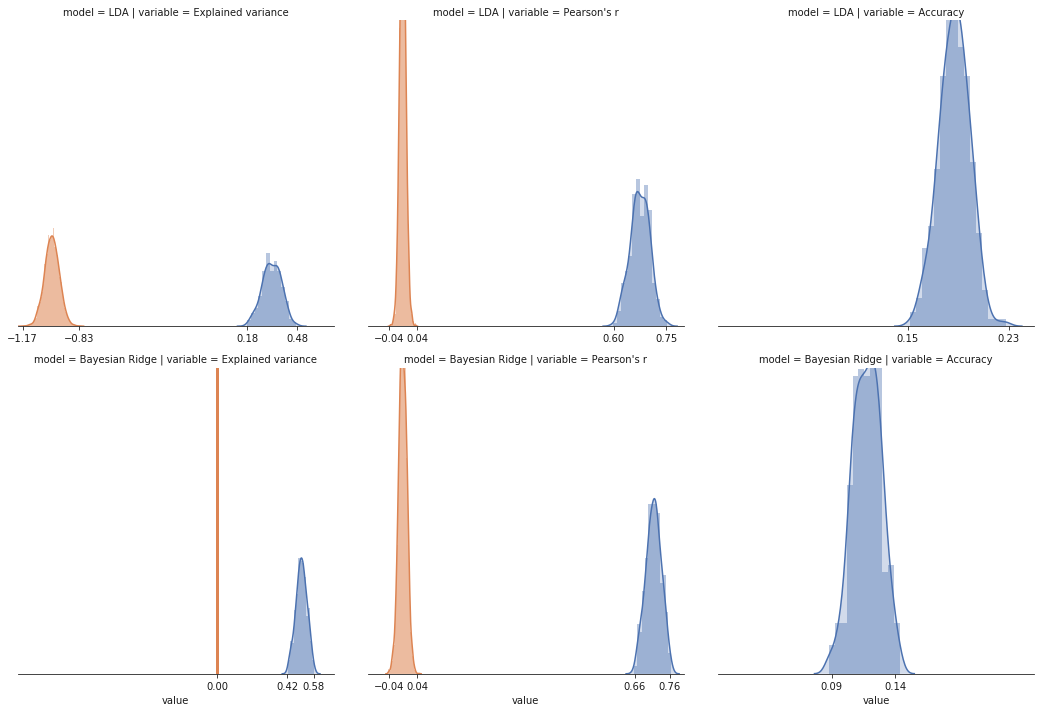

In [534]:
def plot_dist(x, y=None, ax=None, data=None, **kwargs):
    ax = sns.distplot(x,ax=ax, kde_kws=dict(shade=True))
    ticks = ax.get_xticks()
    
    toadd = [x.min().round(2), x.max().round(2)]
    if toadd[1] - toadd[0] < .05:
        print(toadd)
        toadd = [x.mean().round(2)]
        print(toadd)

    if len(ticks) > 4:
        ticks = toadd
    else:
        ticks = list(ticks) + toadd
    ax.set_xticks(ticks)

g = sns.FacetGrid(data = full_metric_table, col='variable', row='model', hue='boot', 
                  sharey=False,size=5, sharex=False)
g.map(plot_dist, 'value')


xlim = [(-1.2, .7), (-.1, .8), (0, 0.25)]
ylim = [(0,30), (0,30)]

# plt.tight_layout()
for i, j in product(range(2), range(3)):
    ax = g.axes[i,j]
    
    ax.set_ylim(ylim[i])
    ax.set_xlim(xlim[j])
    sns.despine(left=True)
    ax.set_yticks([])

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


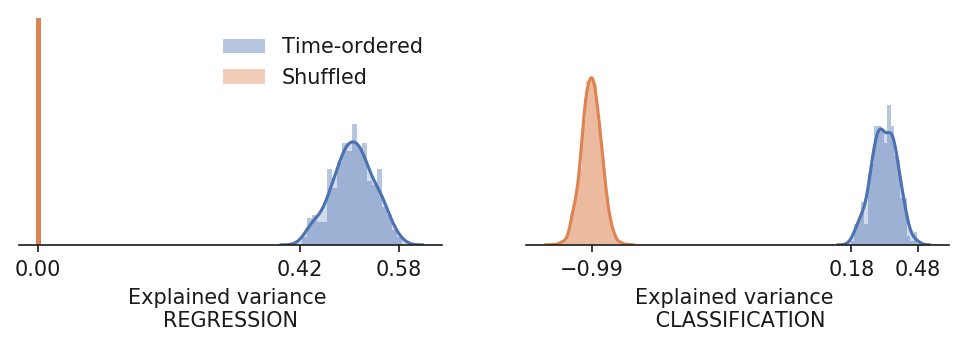

In [629]:
fig, ax = plt.subplots(1,2,figsize=(8,2), dpi=150)
datat = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='Bayesian Ridge') &
                         (full_metric_table.boot==False)].value
sns.distplot(datat, 20, kde_kws=dict(shade=True), ax=ax[0], label='Time-ordered', norm_hist=True)

datab = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='Bayesian Ridge') &
                         (full_metric_table.boot==True)].value
sns.distplot(datab, 20, kde_kws=dict(shade=True), ax=ax[0], label='Shuffled', norm_hist=True)

ax[0].legend(frameon=False)
ax[0].set_ylim(0,25)
ax[0].set_xticks([0, datat.min().round(2),  datat.max().round(2)])
ax[0].set_yticks([])
ax[0].set_xlabel('Explained variance \nREGRESSION')

datat = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='LDA') &
                         (full_metric_table.boot==False)].value
sns.distplot(datat, 20, kde_kws=dict(shade=True), ax=ax[1], norm_hist=True)

datab = full_metric_table[(full_metric_table.variable=='Explained variance') &
                         (full_metric_table.model=='LDA') &
                         (full_metric_table.boot==True)].value
sns.distplot(datab, 20, kde_kws=dict(shade=True), ax=ax[1], norm_hist=True)

ax[1].set_ylim(0,12)
ax[1].set_xticks([datab.mean().round(2), datat.min().round(2),  datat.max().round(2)])
ax[1].set_xlabel("Explained variance \n CLASSIFICATION")
ax[1].set_yticks([])

# ax[0].text(0.01, 10, 'Shuffled', color=sns.color_palette('deep')[1])
# ax[0].text(0.45, 15, 'Time-ordered', color=sns.color_palette('deep')[0])

sns.despine(left=True)

### Regression visualization

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 36.3 s, sys: 53.5 s, total: 1min 29s
Wall time: 4.99 s


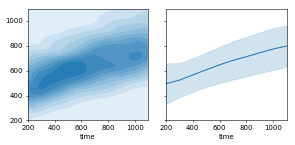

In [168]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=5b0, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100], vertical=False, bw='scott')
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()

##### Testing with full subset

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 51.8 s, sys: 1min 8s, total: 1min 59s
Wall time: 7.97 s


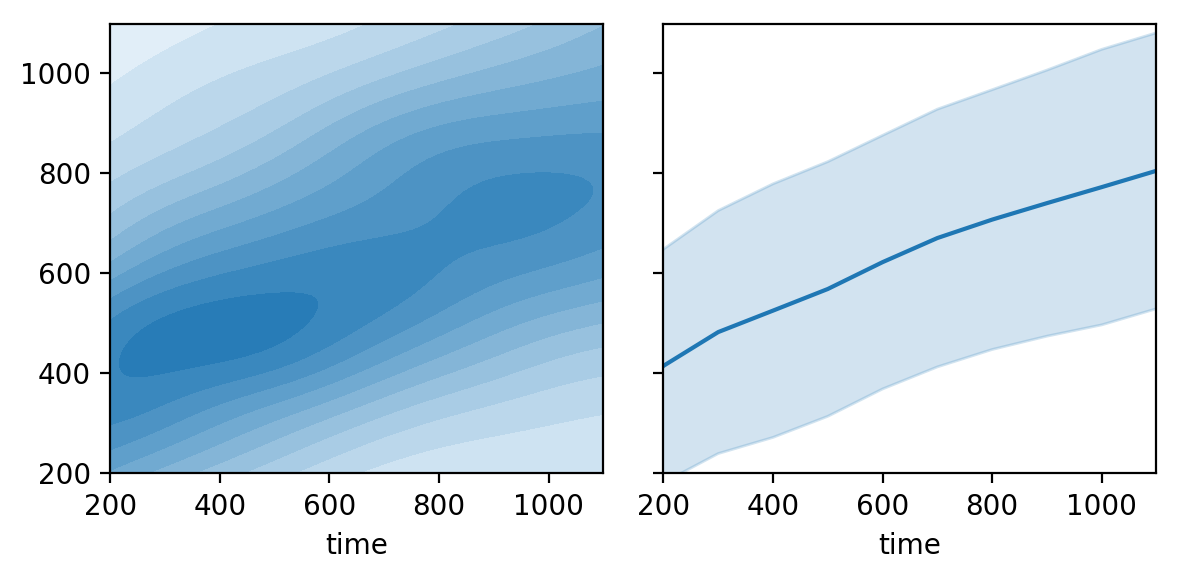

In [162]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()
# plt.suptitle('Regression results')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 41.6 s, sys: 46.6 s, total: 1min 28s
Wall time: 7.12 s


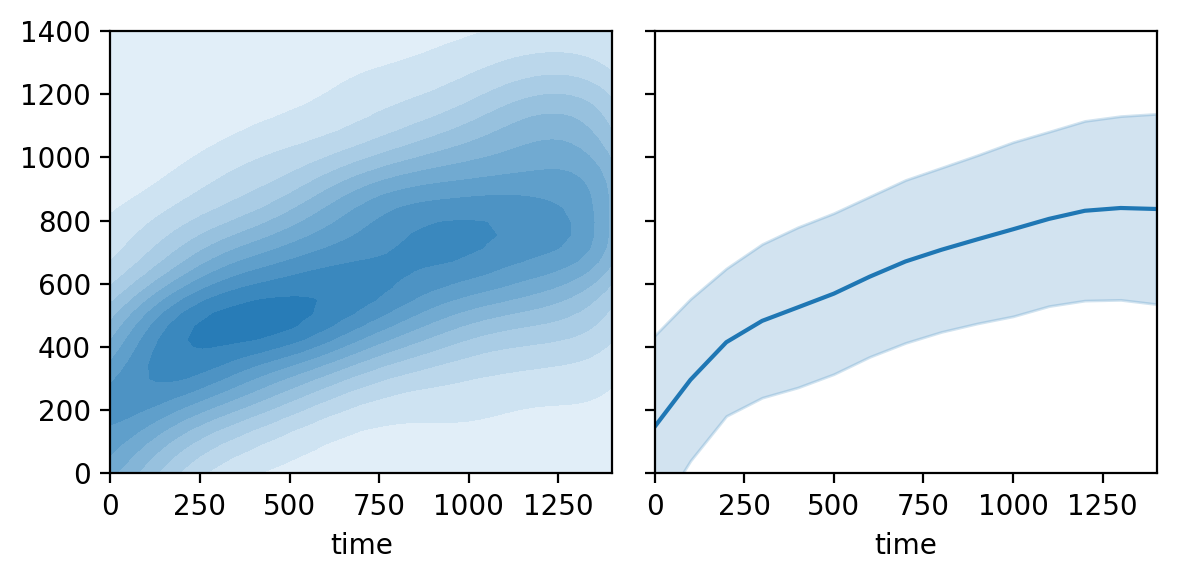

In [161]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0])#, clip=[0,1400])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([0,1400])
plt.xlim([0,1400])

plt.tight_layout()
# plt.suptitle('Regression results')

### Classification visualization

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 28.5 s, sys: 2.54 s, total: 31.1 s
Wall time: 4.12 s


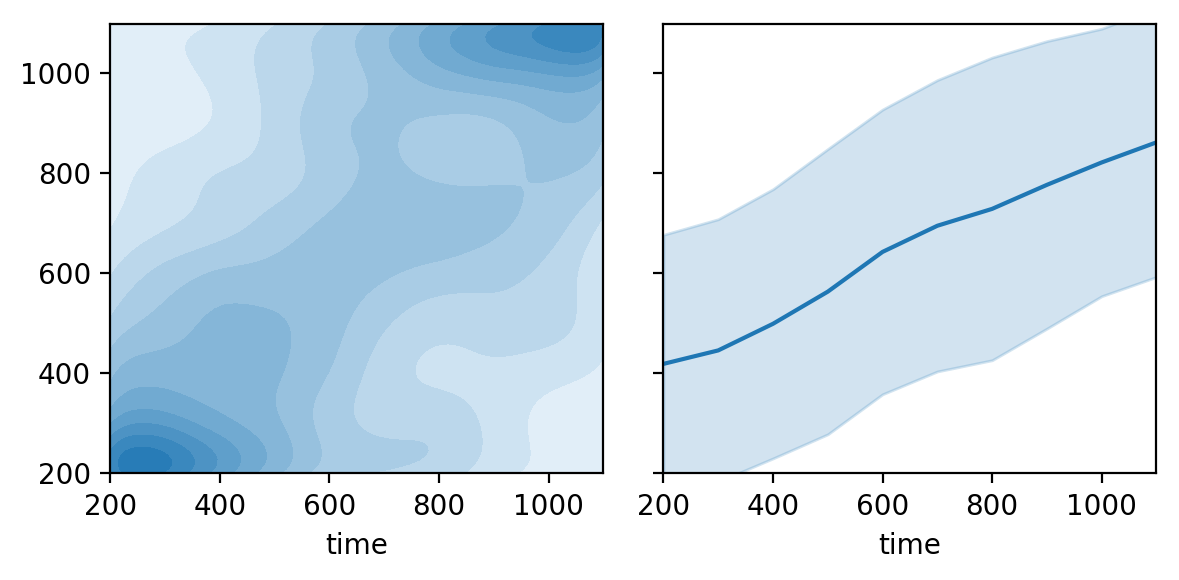

In [153]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = LinearDiscriminantAnalysis()

# Bad rat
X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 34.6 s, sys: 42.3 s, total: 1min 16s
Wall time: 5.09 s


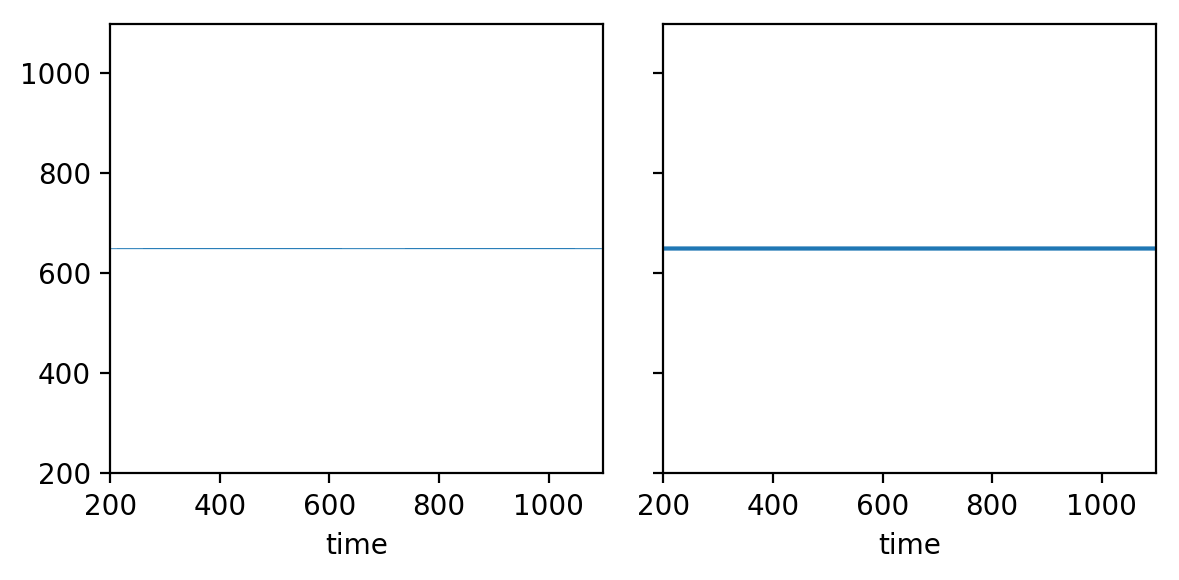

In [154]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = BayesianRidge()

# Bad rat
boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()
# plt.suptitle('Regression results')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 30.3 s, sys: 2.29 s, total: 32.6 s
Wall time: 4.51 s


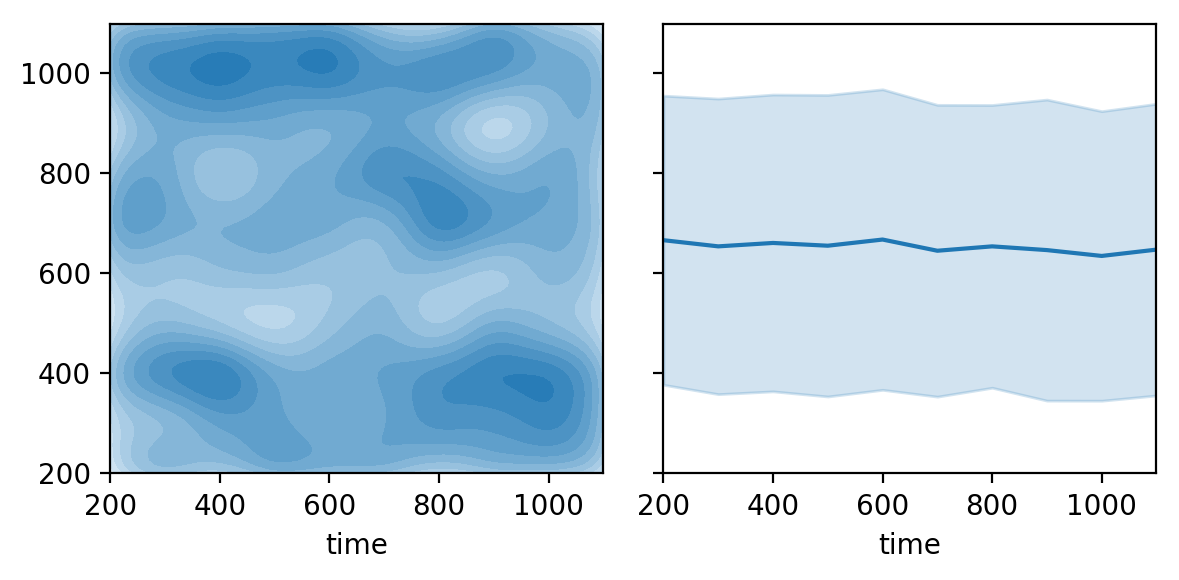

In [155]:
%%time
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=200, sharey=True, sharex=True)
clf = LinearDiscriminantAnalysis()

# Bad rat
boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial

preds = cross_val_predict(clf, X, y, trial, cv=20)

sns.kdeplot(y, preds, shade=True, ax=ax[0], clip=[200,1100])
sns.lineplot(y, preds, ax=ax[1], ci='sd')

plt.ylim([200,1100])
plt.xlim([200,1100])

plt.tight_layout()
# plt.suptitle('Regression results')

### All together 

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 3min 48s, sys: 3min 43s, total: 7min 31s
Wall time: 27.4 s


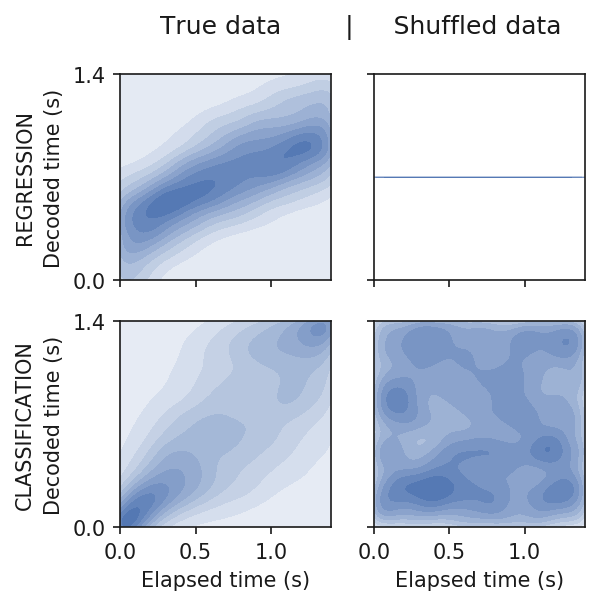

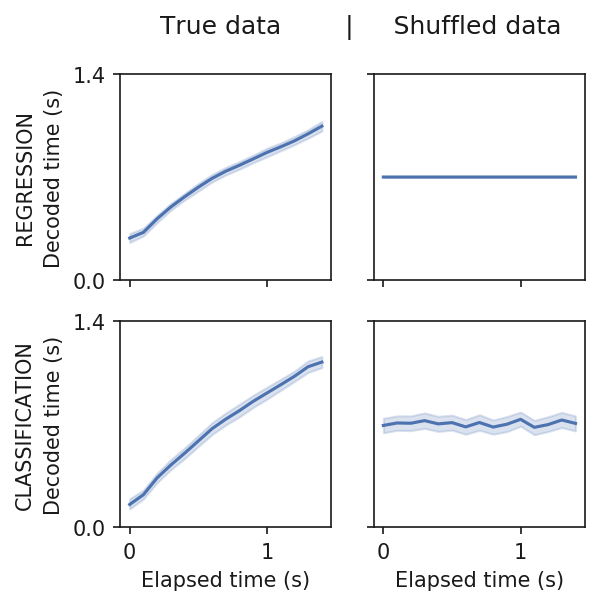

In [419]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
clf = BayesianRidge()

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                               enumerate([False, True])):

    if boot:
        boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[0,1.400], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j])
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([0., 1.4])
    ax_[1,0].set_yticks([0., 1.4])

ax2[0,0].set_ylim([0,1.4])
# plt.xlim([200,1100])


/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CPU times: user 1min 43s, sys: 1min 39s, total: 3min 23s
Wall time: 12.8 s


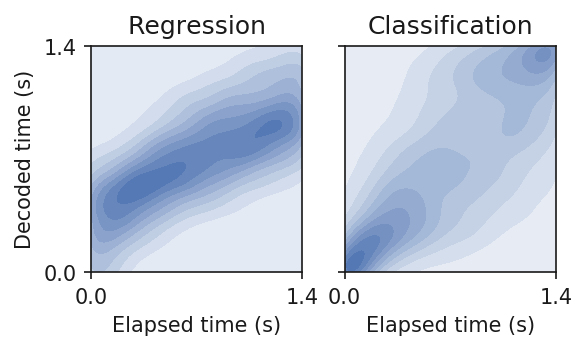

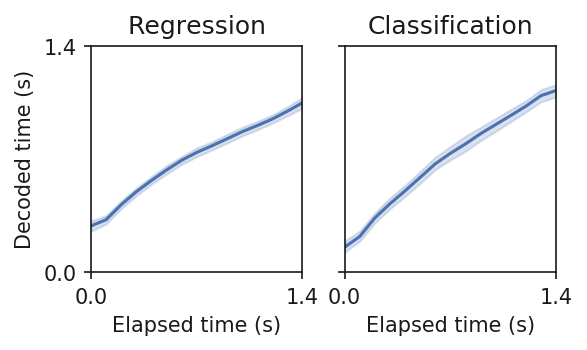

In [421]:
%%time
fig, ax = plt.subplots(1,2, figsize=(4,2), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(1,2, figsize=(4,2), dpi=150, sharey=True, sharex=True)
clf = BayesianRidge()

boot = False
i = 0
for (j, clf) in enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]):

    if boot:
        boot = bs.df_shuffler(merged.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = merged.values, merged.reset_index().time, merged.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[j], clip=[0,1.400], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[j])
    
# fig.suptitle('    Regression        |     Classification')
# fig2.suptitle('    Regression        |     Classification')


for ax_ in [ax, ax2]:

    ax_[0].set_xlabel('Elapsed time (s)')
    ax_[1].set_xlabel('Elapsed time (s)')

    ax_[0].set_ylabel('Decoded time (s)')
    ax_[1].set_ylabel('')

    ax_[0].set_yticks([0., 1.4])
    
    ax_[0].set_xticks([0., 1.4])
    ax_[1].set_xticks([0., 1.4])

    ax_[0].set_title('Regression')
    ax_[1].set_title('Classification')

    ax_[0].set_xlim([0,1.4])

ax2[0].set_ylim([0,1.4])

# plt.xlim([200,1100])


## There is time-warping consistent with timing behavior

# Representation changes with learning

## Striatum enhances its representation while PFC decreases 

## Data loading

In [635]:
day_1_labels = [l for l in SHORTCUTS['groups']['EZ'] if '_2' not in l]
dfs_day1 = [nontired_load(label, 'wide_smoothed') for label in day_1_labels]
pfc_day1 = frankenstein(dfs_day1, _min_duration=1.5, area = 'PFC', subset='full')
str_day1 = frankenstein(dfs_day1, _min_duration=1.5, area = 'STR', subset='full')

day_2_labels = [l for l in SHORTCUTS['groups']['EZ'] if '_2' in l]
dfs_day2 = [nontired_load(label, 'wide_smoothed') for label in day_2_labels]
pfc_day2 = frankenstein(dfs_day2, _min_duration=1.5, area = 'PFC', subset='full')
str_day2 = frankenstein(dfs_day2, _min_duration=1.5, area = 'STR', subset='full')

543 543
436 287
509 500
936 761
625 625
381 380
437 437
699 699


In [645]:
drec = {}
drec[('PFC', 1)] = pfc_day1
drec[('PFC', 2)] = pfc_day2
drec[('STR', 1)] = str_day1
drec[('STR', 2)] = str_day2

In [646]:
n_features_pfc = min(pfc_day2.shape[1], pfc_day1.shape[1])
n_features_str = min(str_day2.shape[1], str_day1.shape[1])
print('Minimum of neuron in Striatum: ', n_features_str)
print('Minimum of neuron in Pre Frontal Cortex: ', n_features_pfc)
n_features = min(n_features_str, n_features_pfc)
print('Number of features to use: ', n_features)

feat_undersampler = MonteCarloFeatures(n_features)
pipe = make_pipeline(feat_undersampler, RobustScaler(), BayesianRidge())

Minimum of neuron in Striatum:  55
Minimum of neuron in Pre Frontal Cortex:  46
Number of features to use:  46


## Metric calculations

In [638]:
# merged = frankenstein(dfs, _min_duration=1.5, is_tired=False, is_selected=True)
size = merged.shape[0]

half1 = merged[:size//2]
half2 = merged[size//2:]

res1 = cross_val(half1, pipe)
res2 = cross_val(half2, pipe)

print(res1.groupby('variable').mean())
print(res2.groupby('variable').mean())

                       value
variable                    
Accuracy            0.101885
Explained variance  0.357692
Pearson's r         0.599093
                       value
variable                    
Accuracy            0.094069
Explained variance  0.285240
Pearson's r         0.541166


In [639]:
res1['Session stage'] = 'Beginning'
res2['Session stage'] = 'Ending'
pres = pd.concat([res1,res2])

In [651]:
res = pd.DataFrame()
for df, name in zip([pfc_day1, str_day1, pfc_day2, str_day2], 
                    ['pfc_day1','str_day1','pfc_day2','str_day2']):
    print(df.shape)
    %time local = cross_val(df, pipe, 1000)
    local['area'] = name[:3]
    local['day'] = name[-1]
    res = res.append(local)

(1755, 46)
CPU times: user 19min 5s, sys: 26min 36s, total: 45min 41s
Wall time: 1min 8s
(1755, 55)
CPU times: user 20min 44s, sys: 28min 40s, total: 49min 24s
Wall time: 1min 14s
(3045, 50)
CPU times: user 26min 15s, sys: 35min 59s, total: 1h 2min 15s
Wall time: 1min 34s
(3045, 60)
CPU times: user 25min 57s, sys: 35min 48s, total: 1h 1min 46s
Wall time: 1min 34s


In [648]:
res['area'] = res['area'].apply(lambda s: 'Pre Frontal Cortex' if s=='pfc' else 'Striatum')

### Visualization

#### Pearson

In [432]:
sns.set_palette('deep')

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


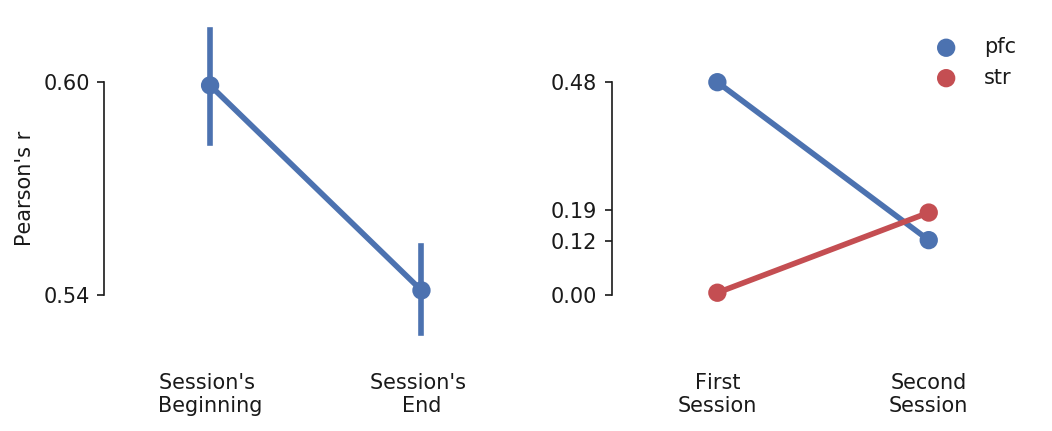

In [652]:
VPAD = .3

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Pearson's r"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Pearson's r"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Pearson's r"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Pearson's r")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)
# ax[0].set_title('A)' + 50*' ')

vals = res[res.variable=="Pearson's r"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)
# ax[1].set_title('B)' + 50*' ')

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


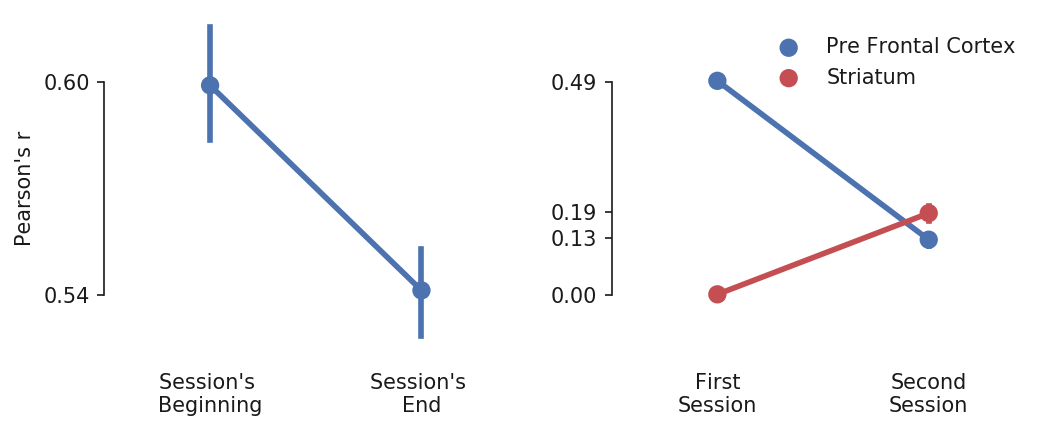

In [642]:
VPAD = .3

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Pearson's r"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Pearson's r"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Pearson's r"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Pearson's r")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)
# ax[0].set_title('A)' + 50*' ')

vals = res[res.variable=="Pearson's r"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)
# ax[1].set_title('B)' + 50*' ')

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


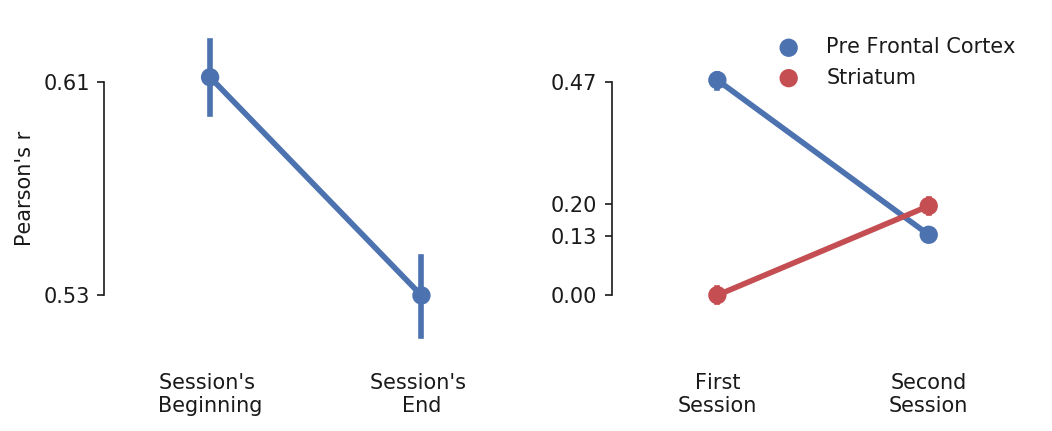

In [631]:
VPAD = .3

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Pearson's r"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Pearson's r"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Pearson's r"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Pearson's r")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)
# ax[0].set_title('A)' + 50*' ')

vals = res[res.variable=="Pearson's r"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)
# ax[1].set_title('B)' + 50*' ')

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [620]:
t=ttest_ind(pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Pearson's r") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Pearson's r") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])


P-value for PFC half vs half: 			 1.0601248163695676e-13
P-value for PFC session 1 vs session 2: 	 8.175280560489555e-86
P-value for Striatum session 1 vs session 2: 	 1.293337358169576e-41
t-value for PFC half vs half: 			 7.99448718718842
t-value for PFC session 1 vs session 2: 	 34.56511170136223
t-value for Striatum session 1 vs session 2: 	 -17.351884417176176


#### Explained variance 

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


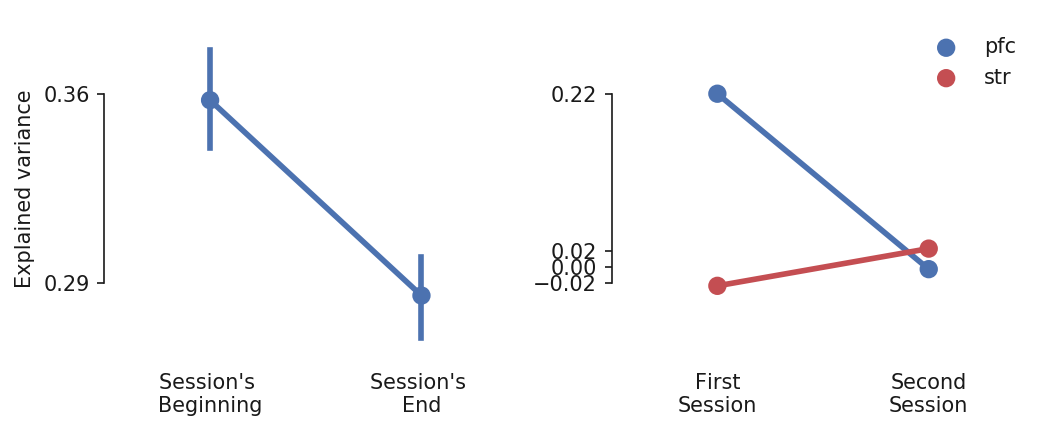

In [653]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Explained variance"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Explained variance"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Explained variance"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Explained variance")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Explained variance"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


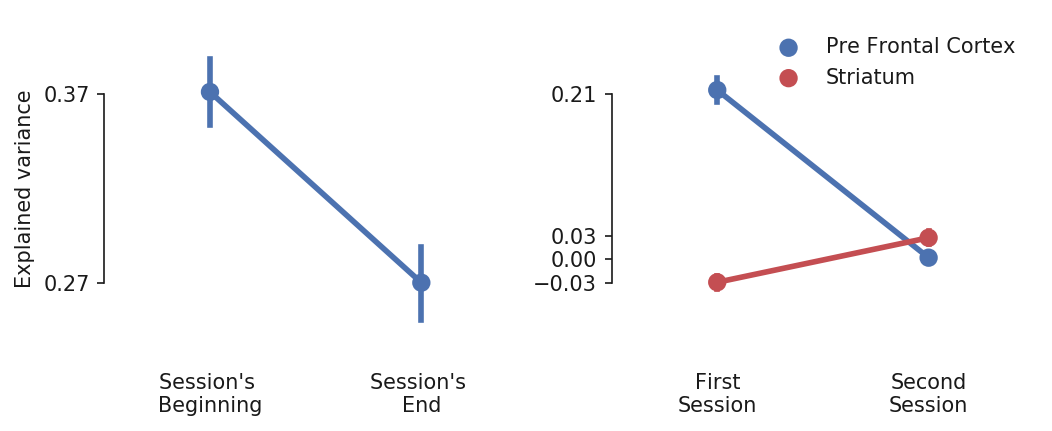

In [632]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Explained variance"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Explained variance"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Explained variance"].groupby('Session stage').mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Explained variance")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Explained variance"].groupby(['area', 'day']).mean().round(2).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [622]:
t=ttest_ind(pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Explained variance") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Explained variance") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Explained variance") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])

P-value for PFC half vs half: 			 5.174408314111714e-13
P-value for PFC session 1 vs session 2: 	 2.013906435843497e-62
P-value for Striatum session 1 vs session 2: 	 1.626000961697324e-17
t-value for PFC half vs half: 			 7.733968489445018
t-value for PFC session 1 vs session 2: 	 24.71545898052013
t-value for Striatum session 1 vs session 2: 	 -9.374777856709748


#### Accuracy

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


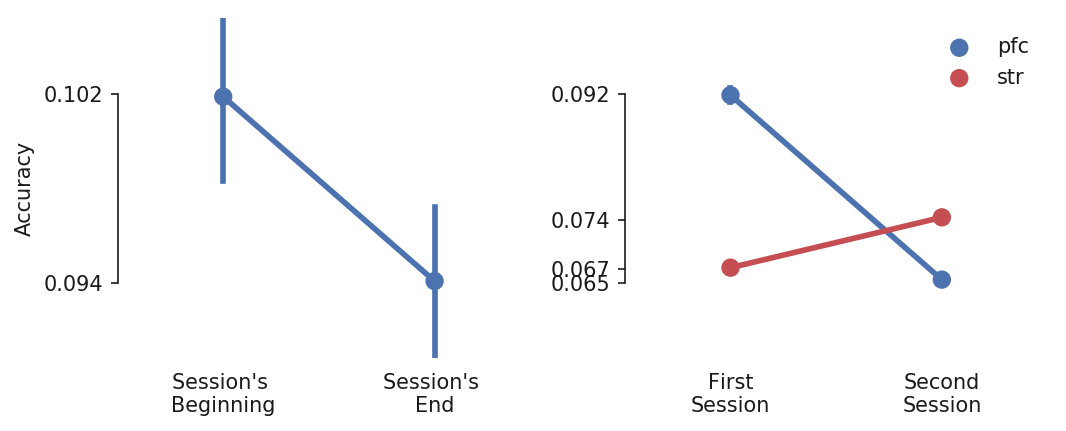

In [654]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Accuracy"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Accuracy"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Accuracy"].groupby('Session stage').mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Accuracy")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Accuracy"].groupby(['area', 'day']).mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


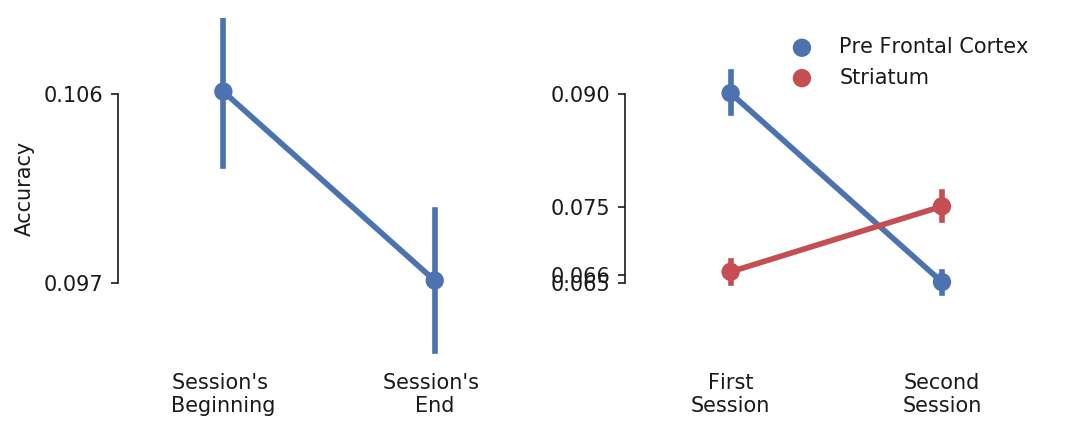

In [634]:
VPAD = .4

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)
sns.pointplot(x='Session stage', y='value', data=pres[pres.variable=="Accuracy"], ax=ax[0])
sns.pointplot(x='day', y='value', hue='area', data=res[res.variable=="Accuracy"], ax=ax[1], palette=['b','r'])
ax[1].set_xlabel('')
ax[0].set_xlabel('')

vals = pres[pres.variable=="Accuracy"].groupby('Session stage').mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[0].set_yticks(vals)
ax[0].set_ylim(vals[0]-pad, vals[1]+pad)
# ax[0].set_xlim(-.2, 1.2)
ax[0].set_ylabel("Accuracy")
ax[0].set_xticklabels(["Session's \nBeginning", "Session's \nEnd"])
ax[0].spines['left'].set_bounds(*vals)
ax[0].tick_params(axis='x', bottom=False)

vals = res[res.variable=="Accuracy"].groupby(['area', 'day']).mean().round(3).sort_values('value').values
pad = (vals[-1] - vals[0])*VPAD
ax[1].set_ylim(vals[0]-pad, vals[-1]+pad)
# ax[1].set_xlim(-.2, 1.2)
ax[1].set_ylabel("")
ax[1].set_yticks(vals)
ax[1].set_xticklabels(["First\nSession", "Second\nSession"])
ax[1].spines['left'].set_bounds(vals[0], vals[-1])
ax[1].tick_params(axis='x', bottom=False)

sns.despine(bottom=True)
plt.legend(title='', frameon=False)

In [444]:
t=ttest_ind(pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Ending')].value.values )
print('P-value for PFC half vs half: \t\t\t', t[1])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('P-value for PFC session 1 vs session 2: \t', t[1])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('P-value for Striatum session 1 vs session 2: \t', t[1])

t=ttest_ind(pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Beginning')].value.values,
          pres[(pres.variable=="Accuracy") & (pres['Session stage']=='Ending')].value.values )
print('t-value for PFC half vs half: \t\t\t', t[0])

pfc = res[(res.area=='Pre Frontal Cortex')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('t-value for PFC session 1 vs session 2: \t', t[0])


pfc = res[(res.area=='Striatum')]
t=ttest_ind(pfc[(pfc.variable=="Accuracy") & (pfc['day']=='1')].value.values,
          pfc[(pfc.variable=="Accuracy") & (pfc['day']=='2')].value.values )
print('t-value for Striatum session 1 vs session 2: \t', t[0])

P-value for PFC half vs half: 			 0.00045509316063258444
P-value for PFC session 1 vs session 2: 	 0.004275497815065561
P-value for Striatum session 1 vs session 2: 	 6.154749410040878e-07
t-value for PFC half vs half: 			 3.5656193029119128
t-value for PFC session 1 vs session 2: 	 2.89049809486012
t-value for Striatum session 1 vs session 2: 	 -5.153852153822333


## Prediction visualizations

### Striatum

#### Day 1 

In [351]:
str_shuf = str_day1.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 1min 7s, sys: 48.3 s, total: 1min 55s
Wall time: 8.83 s


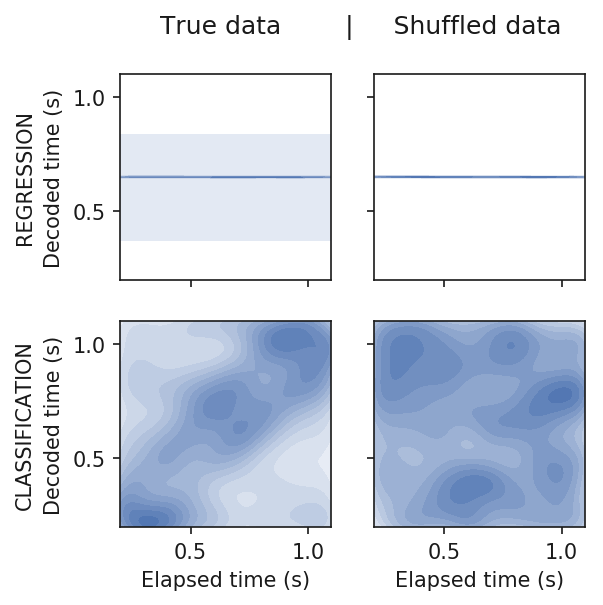

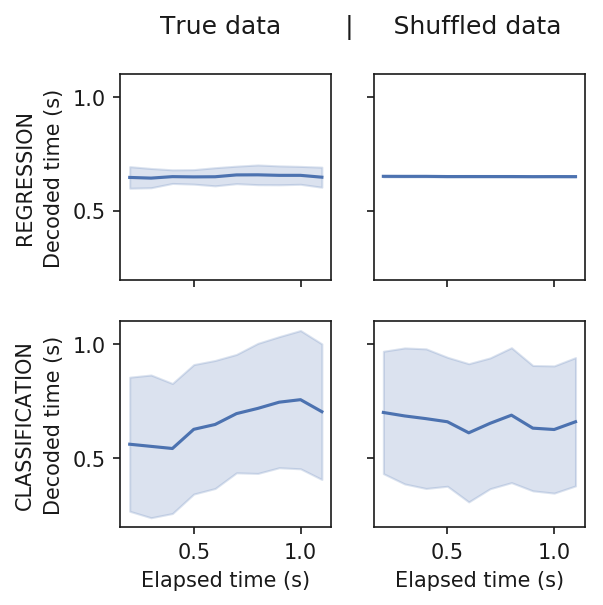

In [352]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)

    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


#### Day 2

In [353]:
str_shuf = str_day2.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 1min 13s, sys: 49.9 s, total: 2min 3s
Wall time: 11.7 s


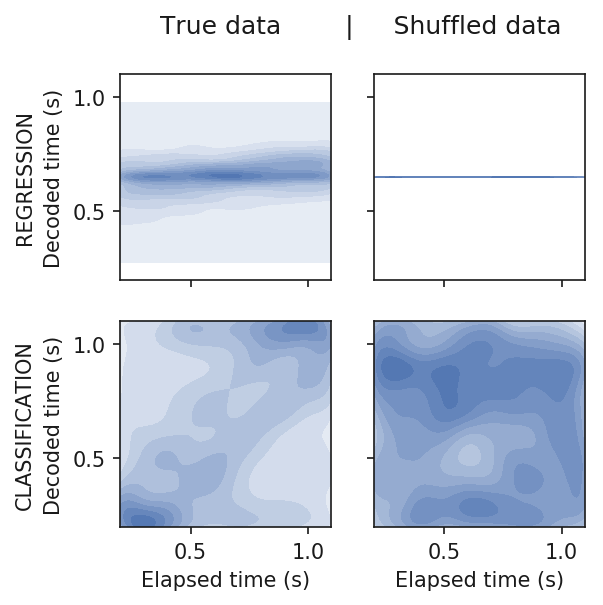

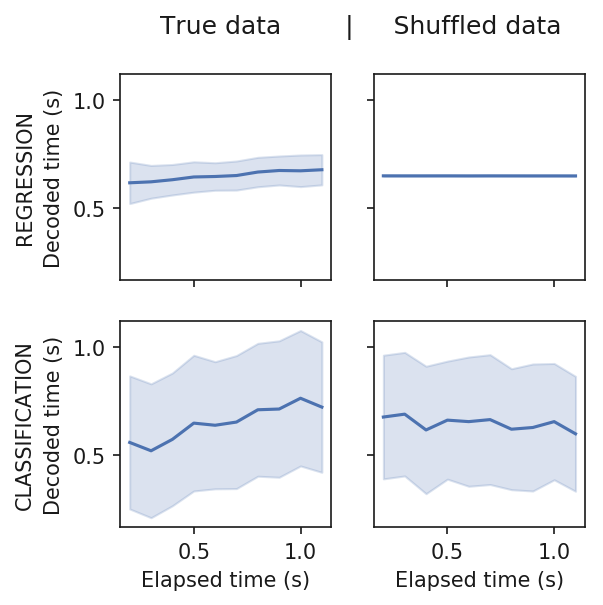

In [354]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)
    
    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


### Pre Frontal Cortex

#### Day 1 

In [355]:
str_shuf = pfc_day1.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 1min 19s, sys: 1min 7s, total: 2min 27s
Wall time: 9.77 s


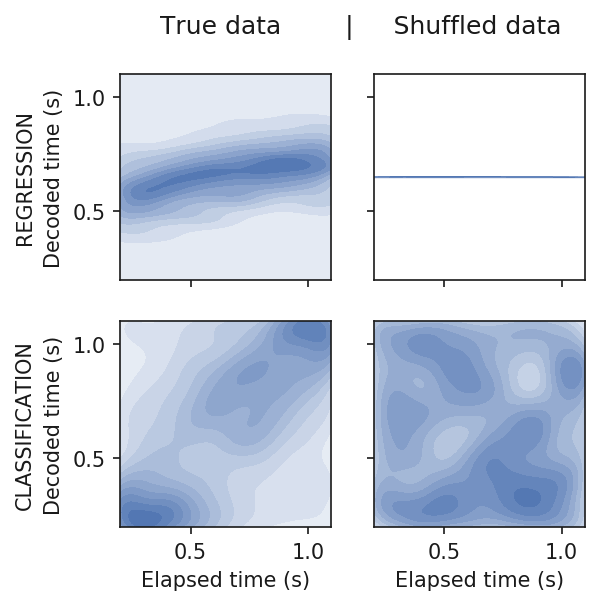

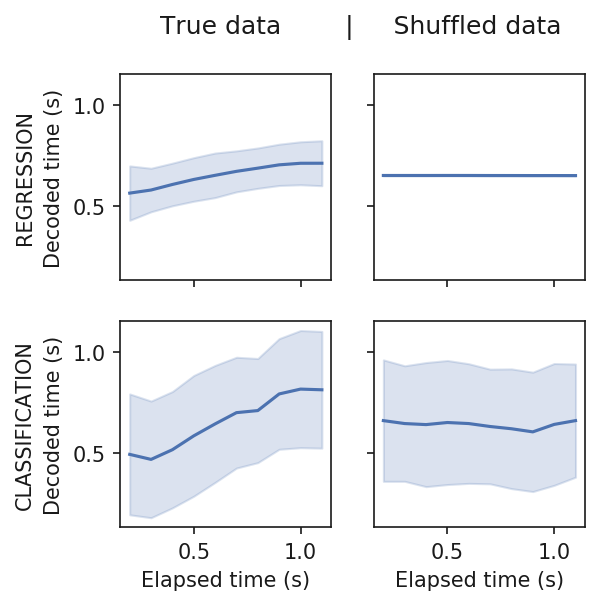

In [356]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)

    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


#### Day 2

In [357]:
str_shuf = pfc_day2.sample(frac=1.)

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 1min 34s, sys: 1min 19s, total: 2min 54s
Wall time: 12.7 s


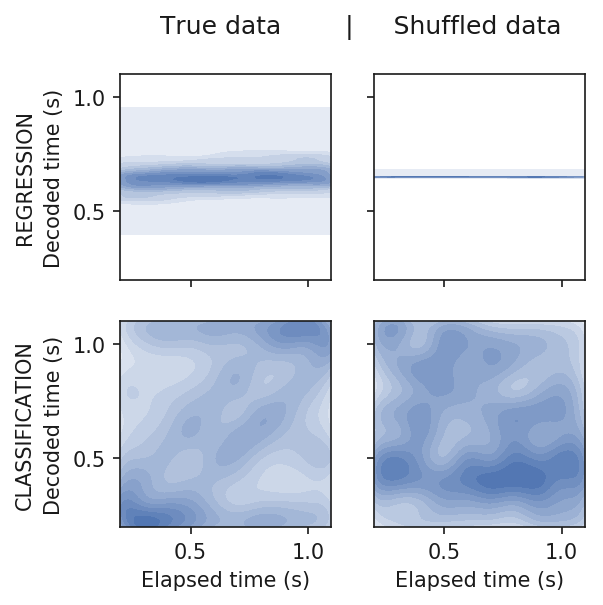

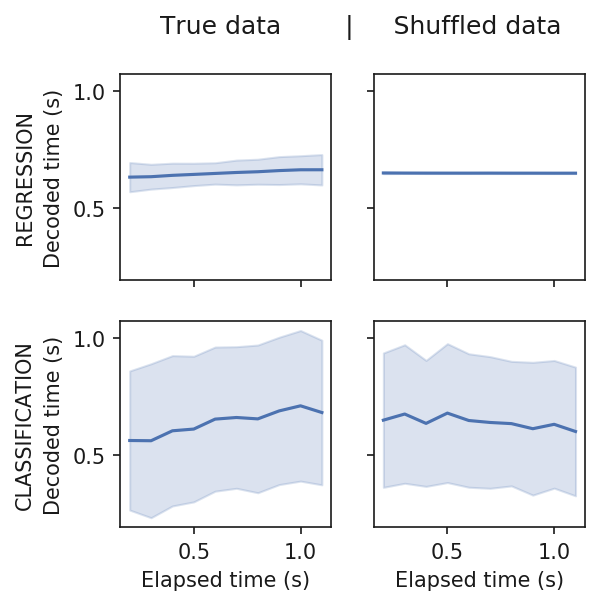

In [358]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)

for (i, clf), (j, boot) in product(enumerate([BayesianRidge(), LinearDiscriminantAnalysis()]),
                                  enumerate([False, True])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)
    
    if boot:
        boot = bs.df_shuffler(str_shuf.reset_index()).set_index(['trial', 'time'])
        X,y, trial = boot.values, boot.reset_index().time, boot.reset_index().trial
    else:
        X,y, trial = str_shuf.values, str_shuf.reset_index().time, str_shuf.reset_index().trial

    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[.200,1.100], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    True data        |     Shuffled data')
fig2.suptitle('    True data        |     Shuffled data')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'REGRESSION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'CLASSIFICATION', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])


### All together

/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/disk1/home/svo6059/anaconda3/envs/spk/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple s

CPU times: user 2min 58s, sys: 3min 16s, total: 6min 14s
Wall time: 19 s


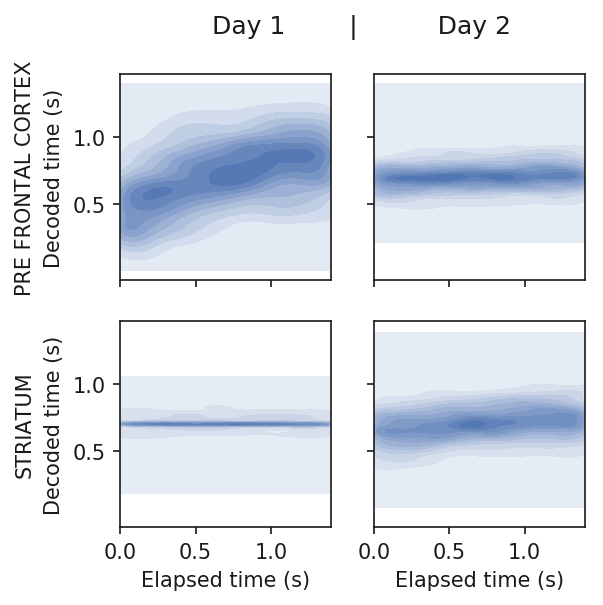

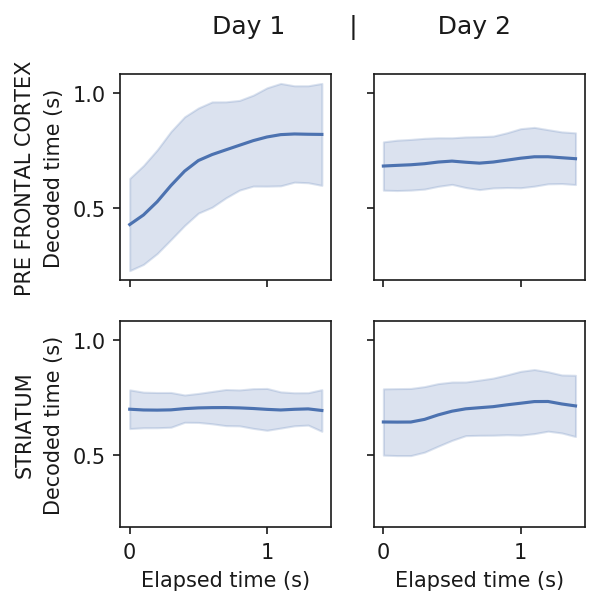

In [628]:
%%time
fig, ax = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
fig2, ax2 = plt.subplots(2,2, figsize=(4,4), dpi=150, sharey=True, sharex=True)
clf = BayesianRidge()
for (i, area), (j, day) in product(enumerate(['PFC', 'STR']),
                                  enumerate([1, 2])):
    
    clf = make_pipeline(feat_undersampler, RobustScaler(), clf)
    df = drec[(area, day)]

    X,y, trial = df.values, df.reset_index().time, df.reset_index().trial
    preds = cross_val_predict(clf, X, y, trial, cv=20)

    sns.kdeplot(y/1000, preds/1000, shade=True, ax=ax[i, j], clip=[0,1.400], vertical=False, bw='scott')
    sns.lineplot(y/1000, preds/1000, ax=ax2[i,j], ci='sd')
    
fig.suptitle('    Day 1        |          Day 2')
fig2.suptitle('    Day 1        |          Day 2')

for ax_ in [ax, ax2]:
    ax_[0,0].text(-.45,.5, 'PRE FRONTAL CORTEX', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[0,0].transAxes)
    ax_[1,0].text(-.45,.5, 'STRIATUM', rotation=90, fontsize=10,
                  horizontalalignment='center', verticalalignment='center', transform=ax_[1,0].transAxes)
    
    ax_[0,0].set_xlabel('')
    ax_[0,1].set_xlabel('')
    ax_[1,0].set_xlabel('Elapsed time (s)')
    ax_[1,1].set_xlabel('Elapsed time (s)')

    ax_[0,0].set_ylabel('Decoded time (s)')
    ax_[0,1].set_ylabel('')
    ax_[1,0].set_ylabel('Decoded time (s)')
    ax_[1,1].set_ylabel('')

    ax_[0,0].set_yticks([.5, 1.])
    ax_[1,0].set_yticks([.5, 1.])
